# Анализ физических лиц: построение тематической модели

Описание модели:
- 400к клиентов 
- данные в виде транзакций
- НЕ темпоральная модель (время не учитывается)
- построена по абсолютным суммам транзакций
- построена по номерам карт
- 30 тем

In [5]:
import sys
sys.path.append('../code')
sys.path.append('/home/filipp/My_pck/bigartm/python')

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import json
import artm
import re
import pickle

In [7]:
import tm_experiments as tme
import tm_metrics as tmm
import segmentation as seg

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
path_mcc = '../data/tr_mcc_codes.csv'
mcc_df = pd.read_csv(path_mcc, sep=';')

mcc_df['mcc_code'] = mcc_df['mcc_code'].astype(str)

print('Number of unique MCC:  ', mcc_df['mcc_code'].nunique())

mcc_df.head()

Number of unique MCC:   290


,mcc_code,mcc_name,mcc_description,mcc_category
0,742,Ветеринарные услуги,"Профессионалы, с лицензией в основном занимающ...",Контрактные услуги
1,763,Сельско-хозяйственные кооперативные общества,"Ассоциации и кооперативы, предлагающие услуги ...",Контрактные услуги
2,780,Ландшафтные и садоводческие магазины,Архитекторы по ландшафту и другие специалисты ...,Контрактные услуги
3,1520,Генеральные подрядчики - жилищное и торговое с...,Генеральные подрядчики в основном занимаются с...,Контрактные услуги
4,1711,"Генеральные подрядчики по вентиляции, теплосна...","Особые строительные (торговые) подрядчики, раб...",Контрактные услуги


In [10]:
mcc2descr = {str(row['mcc_code']): row['mcc_name']
             for index, row in mcc_df.iterrows()}

# Для чего строится модель: клиентов или карт

In [11]:
# user_field = 'client_id_way4'
user_field = 'cardnumber'

#### Загрузка батчей и словаря:

In [13]:
batch_vectorizer = artm.BatchVectorizer(target_folder='../data/tm', 
                                        data_path='../data/vw_400k.txt',
                                        data_format='vowpal_wabbit')

In [14]:
dictionary = batch_vectorizer.dictionary
num_topics = 30  # количество тем
num_back = 1  # количество тем общей лексики

In [15]:
thresholds = [0, 0.3, 0.5, 0.7, 0.9]

# 0. Модель PLSA

In [16]:
model0 = artm.ARTM(num_topics=num_topics, dictionary=dictionary, cache_theta=True, reuse_theta=True, 
                   theta_columns_naming= 'title')
model0.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model0.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore',
                                       topic_names=model0.topic_names[:-num_back]))
model0.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore',
                                         topic_names=model0.topic_names[:-num_back]))
model0.scores.add(artm.TopTokensScore(name='TopTokensScore', dictionary=dictionary))

In [18]:
model0.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [19]:
true_theta = model0.get_theta()

In [21]:
theta = model0.transform(batch_vectorizer)

In [22]:
np.max(true_theta[theta.columns].values - theta.values)

0.040271819

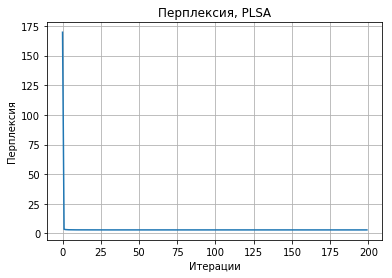

In [23]:
tmm.plot_perplexity(model0, 'PLSA')

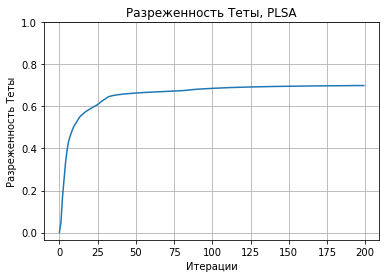

In [24]:
tmm.plot_theta_sparsity(model0, 'PLSA')

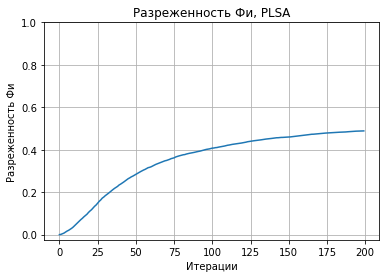

In [25]:
tmm.plot_phi_sparsity(model0, 'PLSA')

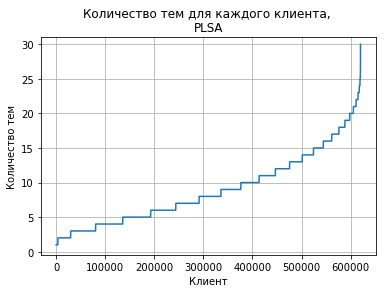

In [27]:
tmm.plot_people_score(model0, 0, '\nPLSA')

[ 2  8 13 14 18 21 25  4 19  1 29 23 10  3 24 17  7 26  5  9 27 22 16 15  6
  0 28 20 11 12]


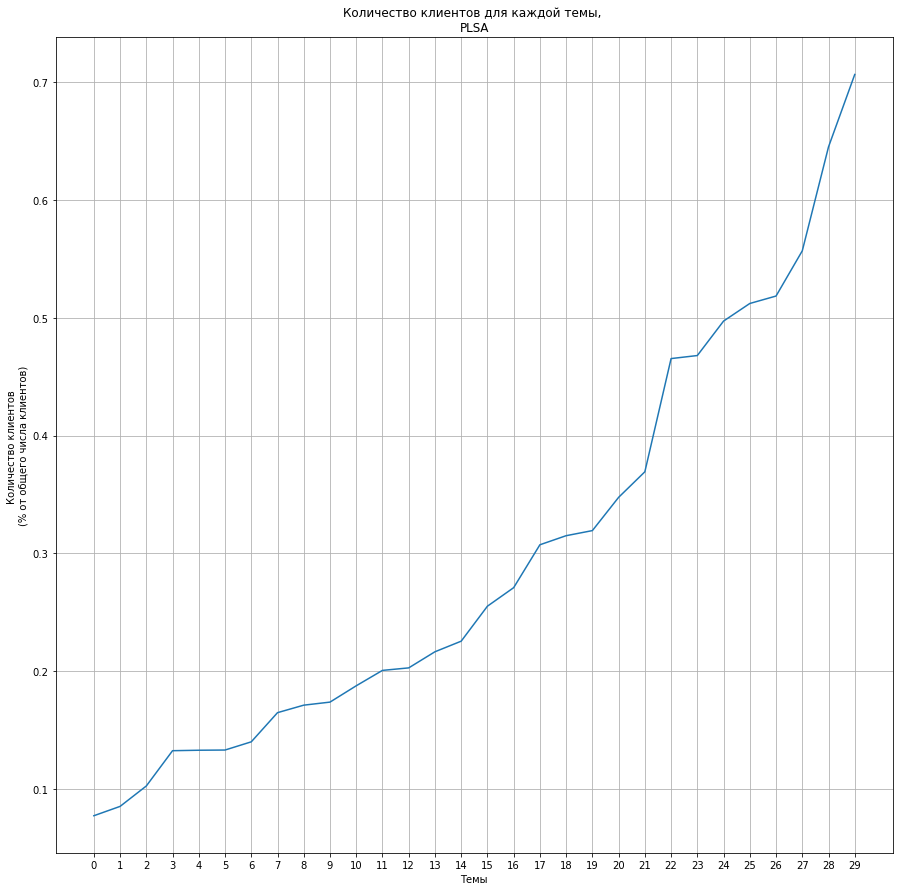

In [39]:
tmm.plot_topics_score(model0, 0, '\nPLSA')

In [41]:
tmm.print_top_tokens(model0, mcc2descr, thresholds, 'PLSA', path='../data/topic_model_files/plsa.txt')

# 1. Разреживание Фи для предметных тем

In [42]:
num_iter = 100

In [43]:
best_tau = -0.3
model1 = model0.clone()
model1.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer',
                                                        tau=best_tau,
                                                        topic_names=model1.topic_names[:-num_back]))
model1.fit_offline(batch_vectorizer=batch_vectorizer,
                   num_collection_passes=num_iter)

model1.regularizers['SparsePhiRegularizer'].tau = 0

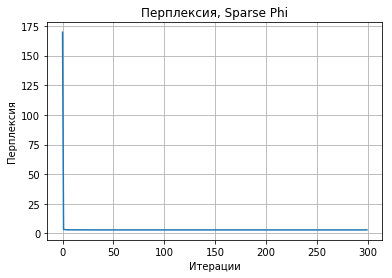

In [44]:
tmm.plot_perplexity(model1, 'Sparse Phi')

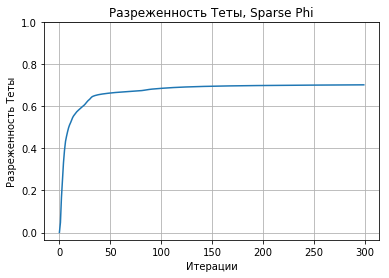

In [45]:
tmm.plot_theta_sparsity(model1, 'Sparse Phi')

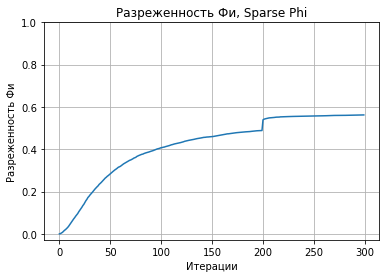

In [46]:
tmm.plot_phi_sparsity(model1, 'Sparse Phi')

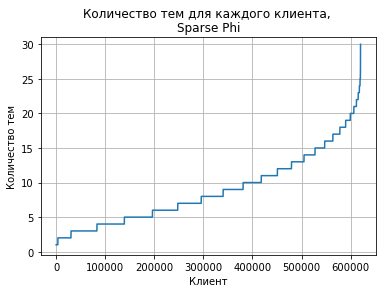

In [47]:
tmm.plot_people_score(model1, 0, '\nSparse Phi')

[ 2  8 13 14 18 21 25 19  4  1 29 23 10  3 24 17  7 26  5  9 27 22 15  6 16
  0 28 20 11 12]


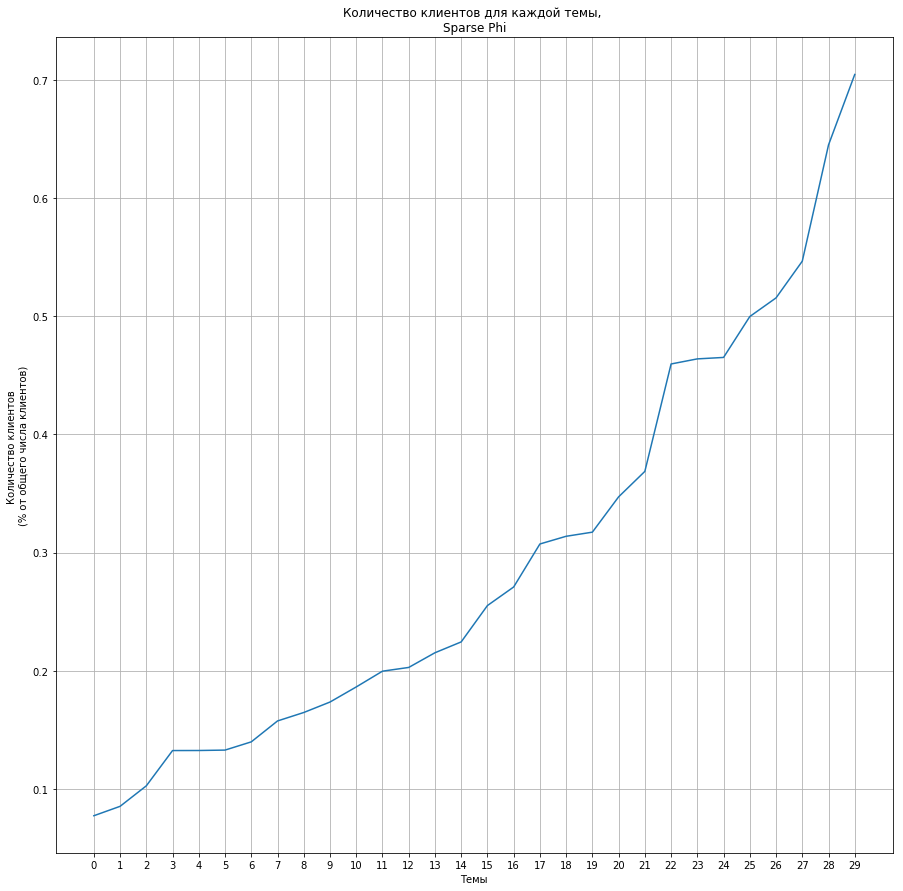

In [48]:
tmm.plot_topics_score(model1, 0, '\nSparse Phi')

In [49]:
tmm.print_top_tokens(model1, mcc2descr, thresholds, 'Sparse Phi', path='../data/topic_model_files/spars_phi.txt')

# 2. Сглаживание Фи для тем общей лексики

Подбор коэффициентов:

In [51]:
best_tau = 0.3
model2 = model1.clone()
model2.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhiRegularizer',
                                                        tau=best_tau,
                                                        topic_names=model2.topic_names[-num_back:]))
model2.fit_offline(batch_vectorizer=batch_vectorizer,
                   num_collection_passes=num_iter)

model2.regularizers['SmoothPhiRegularizer'].tau = 0

In [53]:
tmm.print_top_tokens(model2, mcc2descr, thresholds, 'Smooth Phi', path='../data/topic_model_files/smooth_phi.txt')

# 3. Разреживание Теты для предметных тем

In [55]:
best_tau = -0.3
model3 = model2.clone()
model3.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseThetaRegularizer',
                                                        tau=best_tau,
                                                        topic_names=model3.topic_names[:-num_back]))
model3.fit_offline(batch_vectorizer=batch_vectorizer,
                   num_collection_passes=num_iter)

model3.regularizers['SparseThetaRegularizer'].tau = 0

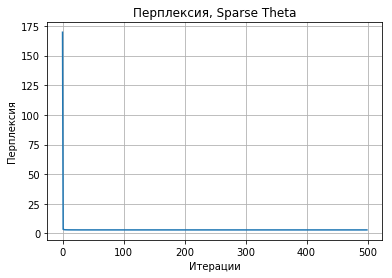

In [57]:
tmm.plot_perplexity(model3, 'Sparse Theta')

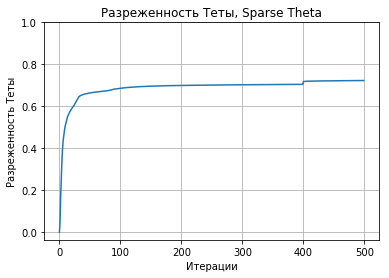

In [59]:
tmm.plot_theta_sparsity(model3, 'Sparse Theta')

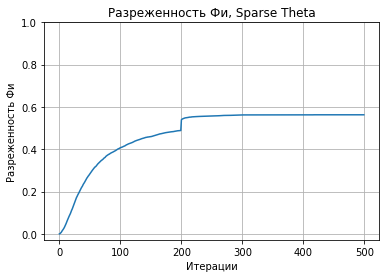

In [61]:
tmm.plot_phi_sparsity(model3, 'Sparse Theta')

[ 2  8 13 21 18 14 25 19  4  1  6 29 23 10  3 24 17  7 26  5  9 27 22 20 15
 16  0 28 11 12]


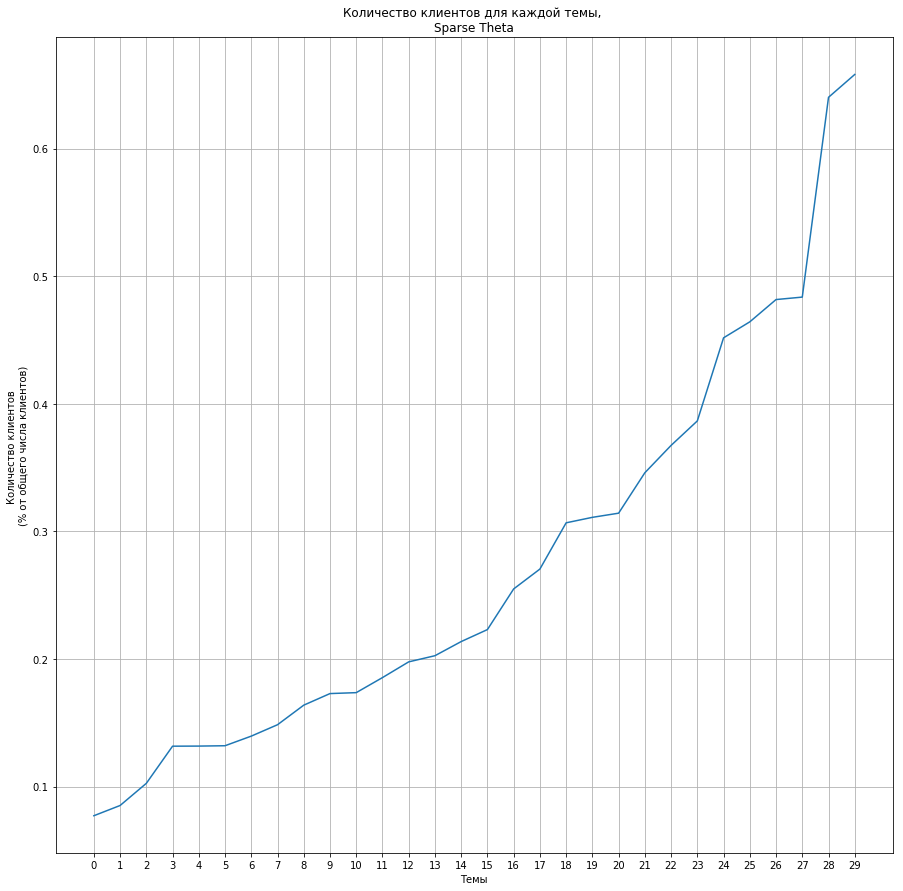

In [63]:
tmm.plot_topics_score(model3, 0, '\nSparse Theta')

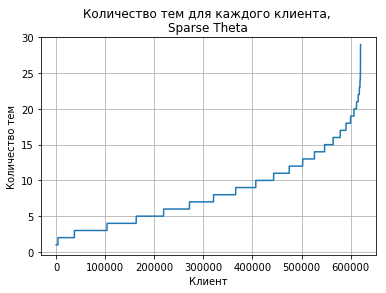

In [65]:
tmm.plot_people_score(model3, 0, '\nSparse Theta')

In [67]:
tmm.print_top_tokens(model3, mcc2descr, thresholds, title='Spase Theta', path='../data/topic_model_files/sparse_theta.txt')

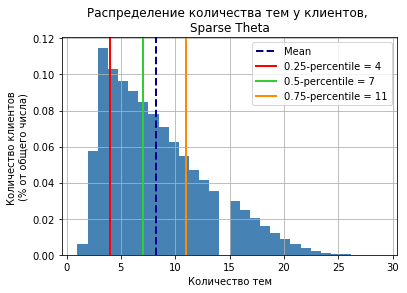

In [69]:
tmm.plot_hist_people_score(model3, 0, '\nSparse Theta')

Сохранение модели:

In [71]:
path_save = '../data/model_30top_400k.artm'
model3.save(path_save)

In [73]:
model3.ptd_name = True

In [75]:
phi = model3.get_phi_sparse()

In [77]:
theta = model3.get_theta_sparse()

In [79]:
np.save('../data/sparce_phi_30top_400k.npy', phi)

In [81]:
np.save('../data/sparce_theta_30top_400k.npy', theta)

In [82]:
theta = model3.get_theta().transpose().to_csv('../data/sparce_theta_30top_400k.npy')

# Использование трансформ

In [84]:
theta_transform = model3.transform(batch_vectorizer)
theta_transform.head()

,148568927,148569152,148569188,148569415,148569607,148571151,148571346,148571566,148572050,148572564,...,1163146,1163260,1163431,1163712,1163891,1164003,1164088,1164332,1164456,1164958
topic_0,0.000000,0.0,0.000000,0.009764,0.0,0.189111,0.0,0.020941,0.116165,0.192833,...,0.000000,0.000000,0.000000,0.000000,0.0,0.003862,0.000000,0.000000,0.000000,0.000000
topic_1,0.118740,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.098265,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.082110,0.000000,0.000000
topic_2,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.021199,0.000000,0.568011,0.000000,0.0,0.000000,0.000000,0.000000,0.023092,0.166186
topic_3,0.009891,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.484237,0.000000,0.000000,0.0,0.000000,0.007526,0.013587,0.000000,0.013330
topic_4,0.000000,0.0,0.001084,0.000780,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.019063,0.000000,0.017954,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [85]:
theta_transform.columns

Index(['148568927', '148569152', '148569188', '148569415', '148569607',
       '148571151', '148571346', '148571566', '148572050', '148572564',
       ...
       '1163146', '1163260', '1163431', '1163712', '1163891', '1164003',
       '1164088', '1164332', '1164456', '1164958'],
      dtype='object', length=620277)

In [87]:
theta_true = model3.get_theta()
theta_true.head()

,148568927,148569152,148569188,148569415,148569607,148571151,148571346,148571566,148572050,148572564,...,1163146,1163260,1163431,1163712,1163891,1164003,1164088,1164332,1164456,1164958
topic_0,0.000000,0.0,0.000000,0.009763,0.0,0.189113,0.0,0.020939,0.116166,0.192834,...,0.00000,0.000000,0.00000,0.000000,0.0,0.003856,0.000000,0.000000,0.000000,0.000000
topic_1,0.118745,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.098267,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.082109,0.000000,0.000000
topic_2,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.02118,0.000000,0.56802,0.000000,0.0,0.000000,0.000000,0.000000,0.023089,0.166186
topic_3,0.009891,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.00000,0.484239,0.00000,0.000000,0.0,0.000000,0.007525,0.013583,0.000000,0.013330
topic_4,0.000000,0.0,0.001083,0.000780,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.00000,0.019063,0.00000,0.017956,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [116]:
theta_transform.head()

,148568927,148569152,148569188,148569415,148569607,148571151,148571346,148571566,148572050,148572564,...,1163146,1163260,1163431,1163712,1163891,1164003,1164088,1164332,1164456,1164958
topic_0,0.000000,0.0,0.000000,0.009764,0.0,0.189111,0.0,0.020941,0.116165,0.192833,...,0.000000,0.000000,0.000000,0.000000,0.0,0.003862,0.000000,0.000000,0.000000,0.000000
topic_1,0.118740,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.098265,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.082110,0.000000,0.000000
topic_2,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.021199,0.000000,0.568011,0.000000,0.0,0.000000,0.000000,0.000000,0.023092,0.166186
topic_3,0.009891,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.484237,0.000000,0.000000,0.0,0.000000,0.007526,0.013587,0.000000,0.013330
topic_4,0.000000,0.0,0.001084,0.000780,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.019063,0.000000,0.017954,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [91]:
diff = (theta_true[theta_transform.columns].values - theta_transform.values)

In [93]:
print(diff.max(), diff.mean(), np.linalg.norm(diff))

0.0442923 -1.16433e-11 0.454188


In [127]:
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, cache_theta=True, reuse_theta=True,
                  theta_columns_naming='title')
path = '../data/topic_model_files/model_30top_400k.artm'
model.load(path, model_name = 'p_wt')
best_tau = -0.3
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseThetaRegularizer',
                                                         tau=best_tau,
                                                         topic_names=model.topic_names[:-num_back]))


In [129]:
theta = model.transform(batch_vectorizer)

In [129]:
diff = (theta_true[theta.columns].values - theta.values)

In [130]:
print(diff.max(), diff.mean(), np.linalg.norm(diff))

1.0 -4.03961e-11 232.839


In [124]:
theta_true

,148568927,148569152,148569188,148569415,148569607,148571151,148571346,148571566,148572050,148572564,...,1163146,1163260,1163431,1163712,1163891,1164003,1164088,1164332,1164456,1164958
topic_0,0.000000,0.000000,0.000000,0.009763,0.000000,0.189113,0.000000,0.020939,0.116166,0.192834,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.003856,0.000000,0.000000,0.000000,0.000000
topic_1,0.118745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098267,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.082109,0.000000,0.000000
topic_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.021180,0.000000,0.568020,0.000000,0.000000,0.000000,0.000000,0.000000,0.023089,0.166186
topic_3,0.009891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.484239,0.000000,0.000000,0.000000,0.000000,0.007525,0.013583,0.000000,0.013330
topic_4,0.000000,0.000000,0.001083,0.000780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.019063,0.000000,0.017956,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_5,0.051365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004153,0.000000,0.000000,0.082071,0.000000,0.000000,0.016996,0.027864,0.000000,0.000000
topic_6,0.000000,0.000000,0.000000,0.000000,0.004464,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.722840
topic_7,0.008421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.006910,0.004357,0.000000,0.000000,0.002628,0.000000,0.000000,0.000000
topic_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.023629,0.001776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_9,0.000000,0.000000,0.000000,0.000000,0.001784,0.000000,0.498786,0.005728,0.000000,0.000000,...,0.000000,0.007547,0.008357,0.000000,0.000000,0.001224,0.007710,0.000000,0.000000,0.000000


# Сравнение всех моделей

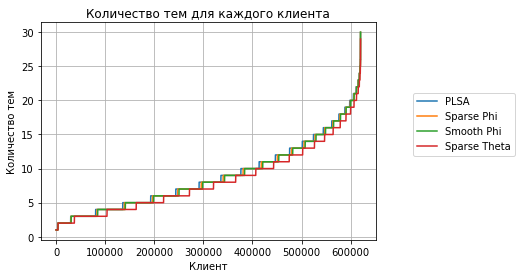

[ 2  8 13 14 18 21 25  4 19  1 29 23 10  3 24 17  7 26  5  9 27 22 16 15  6
  0 28 20 11 12]


[ 2  8 13 14 18 21 25 19  4  1 29 23 10  3 24 17  7 26  5  9 27 22 15  6 16
  0 28 20 11 12]


[ 2  8 13 18 14 21 25 19  4  1 29 23 10  3 24 17  7 26  5  9 27 22  6 15 16
  0 28 20 11 12]


[ 2  8 13 21 18 14 25 19  4  1  6 29 23 10  3 24 17  7 26  5  9 27 22 20 15
 16  0 28 11 12]


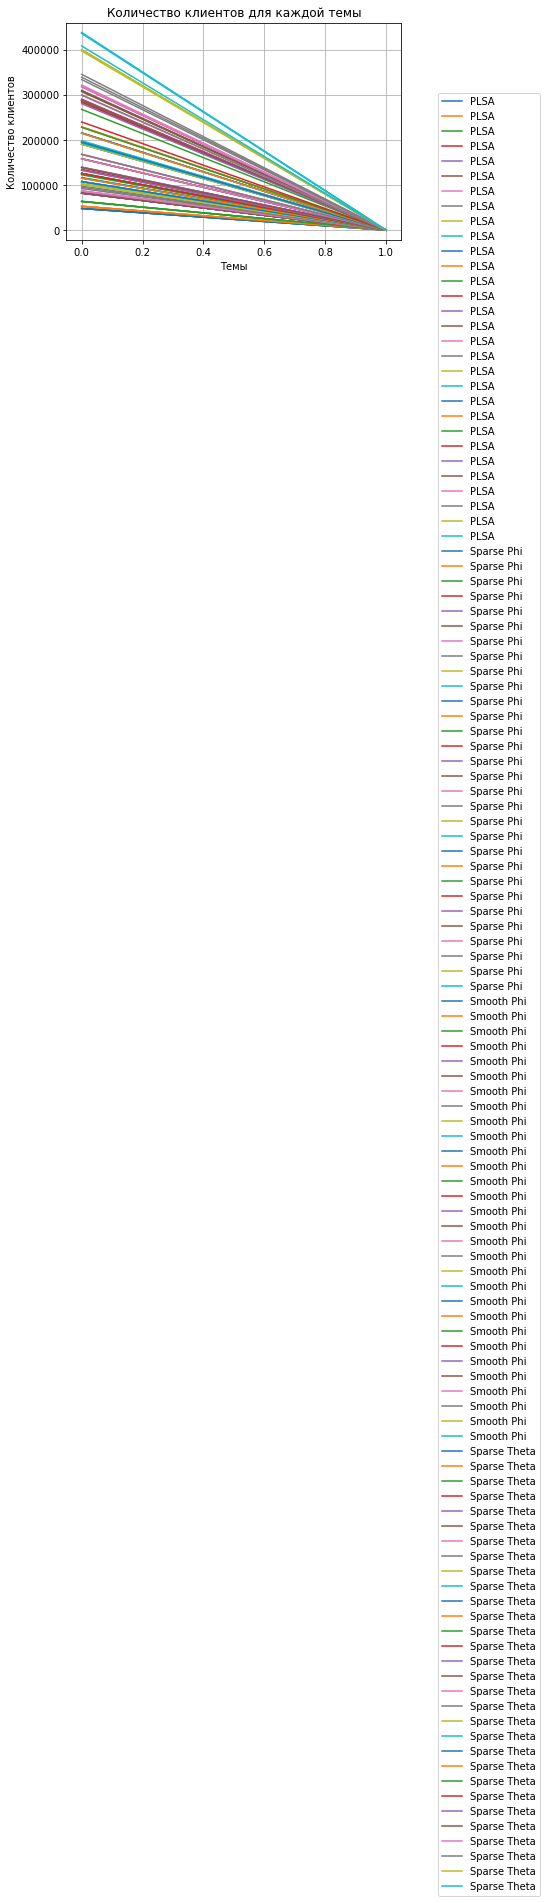

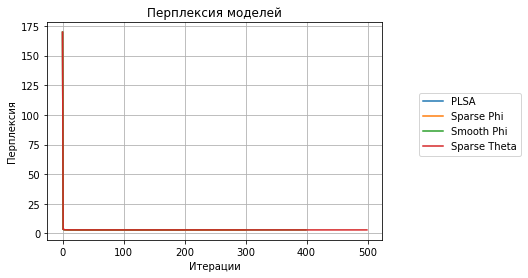

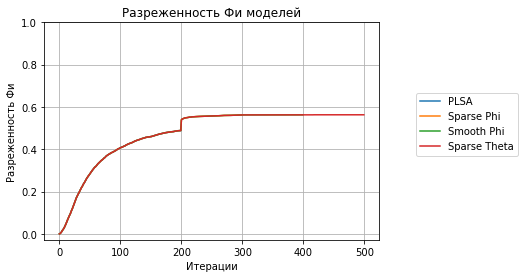

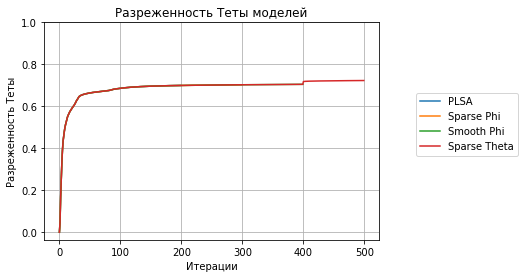

In [126]:
models = [model0, model1, model2, model3]
labels = ['PLSA', 'Sparse Phi', 'Smooth Phi', 'Sparse Theta']

tmm.plot_people_comparison(models, labels)
tmm.plot_topics_comparison(models, labels)
tmm.plot_perplexity_comparison(models, labels)
tmm.plot_phi_sparsity_comparison(models, labels)
tmm.plot_theta_sparsity_comparison(models, labels)

# Сохранение интерпретируемых тем

In [107]:
theta = model3.get_theta()

In [109]:
t = theta.loc['topic_24']
np.sum(t > 0)

138393

In [111]:
failed_id = [7, 25, 34, 5, 23, 38, 14, 19, 1, 46, 40, 39, 42, 20, 37]

In [112]:
not_interpreted_topic_names = ['topic_' + str(i) 
                               for i in failed_id]
intepreted_topic_names = [topic_name 
                          for topic_name in model3.topic_names
                          if topic_name not in not_interpreted_topic_names]
theta = model3.get_theta()

In [113]:
tmm.print_interpreted_rate(theta, intepreted_topic_names, 0.9, 'Sparse Theta')

Model: Sparse Theta, threshold: 90.00%
Interpreted people: 74522
All people:         620277
Percentage:         12.01%


In [114]:
tmm.print_interpreted_rate(theta, intepreted_topic_names, 0.5, 'Sparse Theta')

Model: Sparse Theta, threshold: 50.00%
Interpreted people: 374898
All people:         620277
Percentage:         60.44%


In [115]:
tmm.print_interpreted_rate(theta, intepreted_topic_names, 0.3, 'Sparse Theta')

Model: Sparse Theta, threshold: 30.00%
Interpreted people: 530989
All people:         620277
Percentage:         85.61%


In [115]:
tmm.print_interpreted_rate(theta, intepreted_topic_names, 0, 'Sparse Theta')

Model: Sparse Theta, threshold: 0.00%
Interpreted people: 619139
All people:         620277
Percentage:         99.82%
